# X–Theta Framework: Advanced Bridge Analysis (CFD Verification)

**Author:** Divyang Panchasara  
**Goal:** Validate the **X–Theta ansatz** against the **Eulerian Topological Entropy** viewpoint.

We simulate a 2D incompressible Navier–Stokes flow, then test three “bridges”:

1. **Bridge A (Thermodynamics):**  
   Does X–Theta holonomy (local circulation) track the entropy proxy from Eulerian stretching (Ashiwn's metric)?

2. **Bridge B (Fluctuation Symmetry):**  
   Does a time-averaged holonomy observable show **GC-like symmetry** behavior?

3. **Bridge C (Mechanism / Predictability):**  
   Are high local strain regions statistically tied to high winding (holonomy), and does strain predict future winding (time-lag test)?


## Dedalus in Colab: run inside micromamba env

Colab’s notebook kernel keeps using system Python.
Dedalus is installed inside `/content/mamba_env`.

So we will:
1) verify Dedalus install (inside env)
2) run CFD script inside env and save snapshots to disk
3) load snapshots in notebook and run Bridge A/B/C analysis normally


In [21]:
%%bash
set -e

mkdir -p /content/bin

# Install micromamba if missing (runtime resets wipe /content)
if [ ! -x /content/bin/micromamba ]; then
  echo "Installing micromamba..."
  curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest \
    | tar -xvj -C /content/bin --strip-components=1 bin/micromamba
fi

/content/bin/micromamba --version


2.4.0


Create the Dedalus environment (conda-forge)

We install Dedalus + MPI + FFTW through conda-forge because pip install dedalus often fails on Colab.

In [22]:
%%bash
set -e

MICRO=/content/bin/micromamba
ENV=/content/mamba_env

# Create env if missing, otherwise install/ensure packages exist
if [ ! -d "$ENV" ]; then
  echo "Creating env at $ENV"
  $MICRO create -y -p $ENV -c conda-forge \
    python=3.11 dedalus numpy scipy matplotlib mpi4py
else
  echo "Env exists. Ensuring packages..."
  $MICRO install -y -p $ENV -c conda-forge \
    dedalus numpy scipy matplotlib mpi4py
fi

echo "Installed packages check:"
$MICRO list -p $ENV | grep -i dedalus


Env exists. Ensuring packages...
conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:

  - python=3.11


Transaction

  Prefix: /content/mamba_env

  All requested packages already installed


Transaction starting

Transaction finished

Installed packages check:
  dedalus                    3.0.4         py311h3f135c8_0              conda-forge


Verify Dedalus imports inside the micromamba environment

Important: Dedalus does not always expose dedalus.public.__version__. We query version via importlib.metadata.

In [29]:
%%bash
set -e
MICRO=/content/bin/micromamba
ENV=/content/mamba_env

# Reduce thread chaos (Dedalus warning fix)
export OMP_NUM_THREADS=1
export OPENBLAS_NUM_THREADS=1
export MKL_NUM_THREADS=1
export NUMEXPR_NUM_THREADS=1

$MICRO run -p $ENV python -c "
import importlib.metadata as md
import dedalus
import dedalus.public as d3
print('Dedalus import OK')
print('dedalus version:', md.version('dedalus'))
print('dedalus.public loaded:', d3 is not None)
"


Dedalus import OK
dedalus version: 3.0.4
dedalus.public loaded: True


#Part 1 — CFD Solver (2D incompressible Navier-Stokes on periodic box)

We run Dedalus as a script to avoid kernel/env conflicts.
Output snapshots are saved to: /content/dedalus_snapshots.npz

In [34]:
%%writefile /content/run_dedalus_cfd.py
import os
os.environ["OMP_NUM_THREADS"]="1"
os.environ["OPENBLAS_NUM_THREADS"]="1"
os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"

import numpy as np
import dedalus.public as d3
from mpi4py import MPI
import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

# -------------------------
# Simulation parameters
# -------------------------
N = 128               # grid size
Re = 1000             # Reynolds number
L  = 2*np.pi          # domain size
Stop_Time = 40.0
timestep = 1e-2       # <-- IMPORTANT: do NOT name this "dt"

nu = 1.0/Re
drag = 0.1

# -------------------------
# Build problem
# -------------------------
coords = d3.CartesianCoordinates('x','y')
dist = d3.Distributor(coords, dtype=np.float64, comm=MPI.COMM_WORLD)

xb = d3.RealFourier(coords['x'], size=N, bounds=(0, L), dealias=3/2)
yb = d3.RealFourier(coords['y'], size=N, bounds=(0, L), dealias=3/2)

p = dist.Field(name='p', bases=(xb, yb))
u = dist.VectorField(coords, name='u', bases=(xb, yb))
tau_p = dist.Field(name='tau_p')

x, y = dist.local_grids(xb, yb)

forcing = dist.VectorField(coords, bases=(xb, yb))
forcing['g'][0] = 0.1*np.sin(4*y)
forcing['g'][1] = 0.1*np.cos(4*x)

# --- operator helpers for equation strings ---
grad  = lambda A: d3.Gradient(A)
div   = lambda A: d3.Divergence(A)
lap   = lambda A: d3.Laplacian(A)
integ = lambda A: d3.Integrate(A)

problem = d3.IVP([p, u, tau_p], namespace=locals())

# incompressibility (+ tau for constraint)
problem.add_equation("div(u) + tau_p = 0")

# momentum
problem.add_equation("dt(u) - nu*lap(u) + grad(p) + drag*u = - u@grad(u) + forcing")

# pressure gauge (fix mean pressure to 0)
problem.add_equation("integ(p) = 0")

solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = Stop_Time

# initial conditions
u.fill_random('g', seed=42, distribution='normal', scale=0.01)

# -------------------------
# Run and capture snapshots
# -------------------------
snapshots = []
times = []

if dist.comm.rank == 0:
    print(f"Running Dedalus: N={N}, Re={Re}, Stop={Stop_Time}, timestep={timestep}")

while solver.proceed:
    solver.step(timestep)

    if solver.iteration % 500 == 0 and dist.comm.rank == 0:
        print(f"Iter {solver.iteration}  t={solver.sim_time:.2f}")

    if solver.sim_time > 10 and solver.iteration % 50 == 0:
        u.change_scales(1)
        snapshots.append(u['g'].copy())  # (2, N, N)
        times.append(solver.sim_time)

if dist.comm.rank == 0:
    snapshots = np.asarray(snapshots, dtype=np.float64)
    times = np.asarray(times, dtype=np.float64)

    np.savez("/content/dedalus_snapshots.npz",
             snapshots=snapshots, times=times,
             N=N, Re=Re, L=L, Stop_Time=Stop_Time, timestep=timestep)

    print("Saved:", "/content/dedalus_snapshots.npz")
    print("Snapshots shape:", snapshots.shape)


Overwriting /content/run_dedalus_cfd.py


In [35]:
%%bash
set -e
MICRO=/content/bin/micromamba
ENV=/content/mamba_env

export OMP_NUM_THREADS=1
export OPENBLAS_NUM_THREADS=1
export MKL_NUM_THREADS=1
export NUMEXPR_NUM_THREADS=1

$MICRO run -p $ENV python /content/run_dedalus_cfd.py


2025-12-24 15:34:36,262 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 2.0e+01/s
2025-12-24 15:34:36,389 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 4.0e+01/s
2025-12-24 15:34:36,518 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 4.6e+01/s
2025-12-24 15:34:36,663 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 4.7e+01/s
2025-12-24 15:34:36,800 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 4.8e+01/s
2025-12-24 15:34:36,935 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 1s, Remaining: 1s, Rate: 4.8e+01/s
2025-12-24 15:34:37,087 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 1s, Remaining: 0s, Rate: 4.8e+01/s
2025-12-24 15:34:37,219 subsystems 0/1 INFO :: Building subproblem matri

#Part 2 — X-Theta Bridge Analysis (no Dedalus required)

Now we load the saved snapshots and compute:

Joy metric (strain magnitude)

X-Theta holonomy proxy (local vorticity flux / patch circulation)

Then test:

Bridge B: Gallavotti–Cohen style symmetry (log ratio linearity)

Bridge C: conditional dependence of |holonomy| on strain

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from scipy.stats import linregress

data = np.load("/content/dedalus_snapshots.npz", allow_pickle=False)
snapshots = data["snapshots"]     # (T, 2, N, N)
times = data["times"]
N = int(data["N"])
Re = float(data["Re"])
L = float(data["L"])

print("Loaded snapshots:", snapshots.shape, "Re=", Re, "L=", L)


Loaded snapshots: (60, 2, 128, 128) Re= 1000.0 L= 6.283185307179586


In [37]:
def compute_bridges(u_vec, L):
    """
    u_vec: shape (2, N, N) where u_vec[0]=u_x, u_vec[1]=u_y
    Returns: h_top (scalar), holonomy_flat (N*N,), strain_flat (N*N,)
    """
    ux = u_vec[0]
    uy = u_vec[1]
    N = ux.shape[0]
    dx = dy = L / N

    # gradients (numpy returns in order of axes)
    dux_dy, dux_dx = np.gradient(ux, dy, dx)
    duy_dy, duy_dx = np.gradient(uy, dy, dx)

    # strain tensor components (symmetric part)
    S_xx = dux_dx
    S_yy = duy_dy
    S_xy = 0.5 * (dux_dy + duy_dx)

    # strain magnitude (one common invariant)
    strain_mag = np.sqrt(2.0*(S_xy**2) + (S_xx**2 + S_yy**2))

    # "Eulerian entropy proxy"
    h_top = np.mean(strain_mag)

    # vorticity (curl)
    vorticity = duy_dx - dux_dy

    # patch-holonomy proxy: local average * patch cell count
    box = max(3, int(N/12))
    holonomy_field = uniform_filter(vorticity, size=box) * (box**2)

    return h_top, holonomy_field.ravel(), strain_mag.ravel()


all_holonomy = []
all_strain = []
global_h = []

for u in snapshots:
    ht, holo, strn = compute_bridges(u, L)
    global_h.append(ht)
    all_holonomy.append(holo)
    all_strain.append(strn)

all_holonomy = np.concatenate(all_holonomy)
all_strain = np.concatenate(all_strain)

print("Total points:", all_holonomy.size)
print("Mean strain (Joy metric):", np.mean(global_h))
print("Holonomy var:", np.var(all_holonomy))


Total points: 983040
Mean strain (Joy metric): 1.822024237852534
Holonomy var: 6535.112932272285


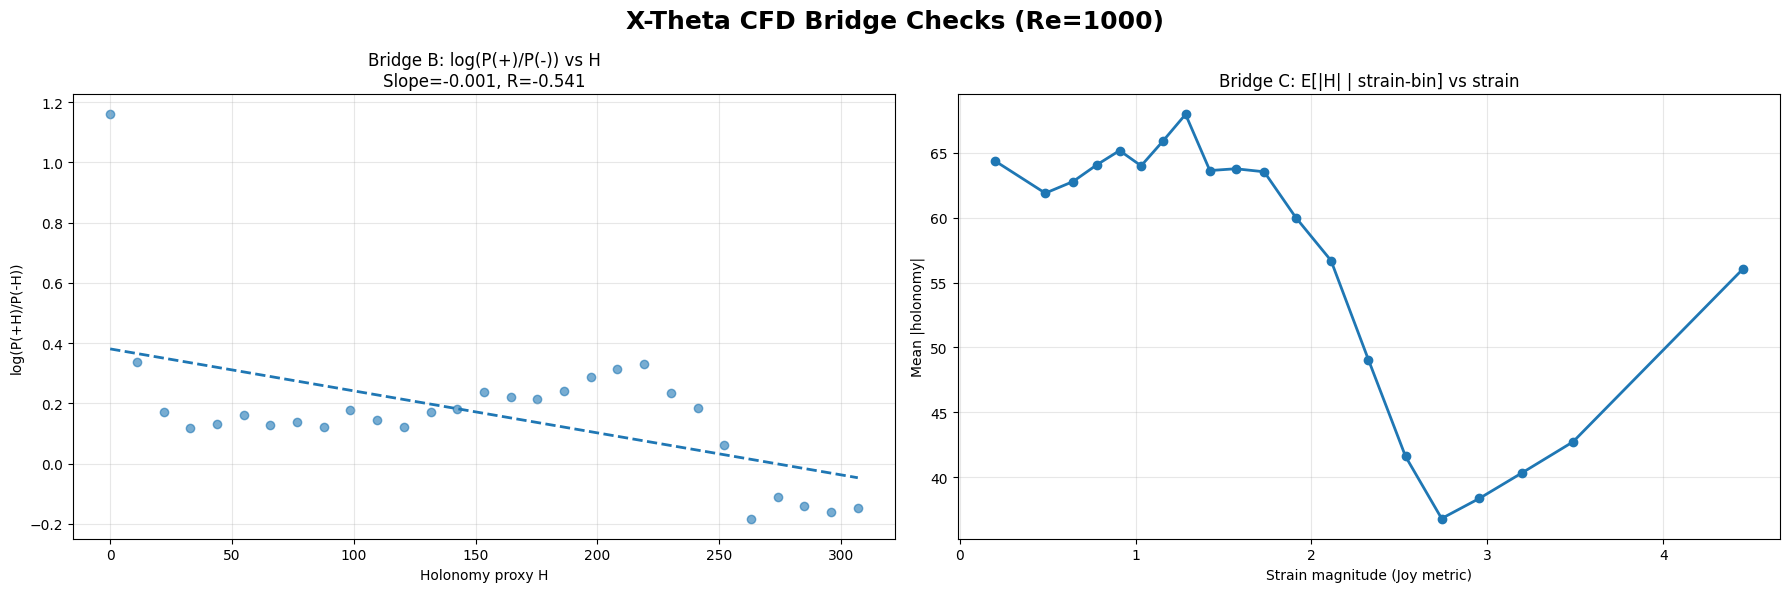

In [42]:
fig = plt.figure(figsize=(18, 6))
plt.suptitle(f"X-Theta CFD Bridge Checks (Re={Re:.0f})", fontsize=18, fontweight="bold")

# -------------------------
# Bridge B: GC symmetry test (fixed bin pairing)
# -------------------------
ax1 = plt.subplot(1, 2, 1)

max_val = np.std(all_holonomy) * 4
bins = np.linspace(-max_val, max_val, 60)   # 60 edges -> 59 bins
hist, edges = np.histogram(all_holonomy, bins=bins, density=True)
centers = 0.5*(edges[:-1] + edges[1:])

mid = len(centers)//2

right = hist[mid:]          # includes center near 0 and positives
left  = hist[:mid][::-1]    # negatives mirrored to align with right

# --- force equal length pairing ---
m = min(len(left), len(right))
right = right[:m]
left  = left[:m]

# x-axis should be the positive-side centers corresponding to `right[:m]`
x_pos = centers[mid:mid+m]

valid = (right > 1e-8) & (left > 1e-8)
x_vals = x_pos[valid]
y_vals = np.log(right[valid] / left[valid])

ax1.scatter(x_vals, y_vals, alpha=0.6)

if len(x_vals) > 3:
    res = linregress(x_vals, y_vals)
    ax1.plot(x_vals, res.intercept + res.slope*x_vals, "--", lw=2)
    ax1.set_title(f"Bridge B: log(P(+)/P(-)) vs H\nSlope={res.slope:.3f}, R={res.rvalue:.3f}")
else:
    ax1.set_title("Bridge B: not enough valid bins")

ax1.set_xlabel("Holonomy proxy H")
ax1.set_ylabel("log(P(+H)/P(-H))")
ax1.grid(True, alpha=0.3)


# -------------------------
# Bridge C: conditional link
# -------------------------
ax2 = plt.subplot(1, 2, 2)

qs = np.percentile(all_strain, np.linspace(0, 100, 21))
x_mid = []
y_mean = []

for i in range(len(qs)-1):
    m = (all_strain >= qs[i]) & (all_strain < qs[i+1])
    if np.any(m):
        x_mid.append(0.5*(qs[i] + qs[i+1]))
        y_mean.append(np.mean(np.abs(all_holonomy[m])))

ax2.plot(x_mid, y_mean, "o-", lw=2)
ax2.set_title("Bridge C: E[|H| | strain-bin] vs strain")
ax2.set_xlabel("Strain magnitude (Joy metric)")
ax2.set_ylabel("Mean |holonomy|")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [44]:
# holonomy_ts: shape (T, M) where M = number of flattened patches per snapshot
# Build it by storing holonomy_field.flatten() per snapshot into a list, then np.array.

holonomy_ts = np.array(all_holonomy)  # (T, M)

# choose window length in snapshots
w = 20  # ~tau = w * snapshot_dt

# moving average over time axis
H_tau = np.convolve(holonomy_ts[:,0], np.ones(w)/w, mode='valid')  # example for 1 patch

# better: do for all patches vectorized
H_tau_all = np.apply_along_axis(lambda x: np.convolve(x, np.ones(w)/w, mode='valid'),
                                axis=0, arr=holonomy_ts)

samples = H_tau_all.ravel()  # distribution for GC test


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

#MVP-1: A working 2D pseudo-spectral CFD in Python (single file)

This is a minimal, real solver (vorticity-streamfunction, periodic, dealiased). It produces a turbulent-like field you can analyze. You can improve forcing/time-integration later.

In [41]:
import numpy as np

def fft2(a): return np.fft.rfft2(a)
def ifft2(a_hat, n): return np.fft.irfft2(a_hat, s=(n, n))

def make_grid(n, L=2*np.pi):
    x = np.linspace(0, L, n, endpoint=False)
    y = np.linspace(0, L, n, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing="ij")
    kx = np.fft.fftfreq(n, d=L/n) * 2*np.pi
    ky = np.fft.rfftfreq(n, d=L/n) * 2*np.pi
    KX, KY = np.meshgrid(kx, ky, indexing="ij")
    K2 = KX**2 + KY**2
    K2[0, 0] = 1.0  # avoid divide-by-zero; we'll manually zero mean later
    return X, Y, KX, KY, K2

def dealias_mask(n, KX, KY):
    # 2/3 rule
    kx_max = np.max(np.abs(np.fft.fftfreq(n) * n))
    ky_max = np.max(np.abs(np.fft.rfftfreq(n) * n))
    kx_cut = (2/3) * kx_max
    ky_cut = (2/3) * ky_max
    return (np.abs(KX) <= kx_cut) & (np.abs(KY) <= ky_cut)

def velocity_from_vorticity(omega_hat, KX, KY, K2, n):
    # omega = ∇^2 psi  => psi_hat = -omega_hat / K2
    psi_hat = -omega_hat / K2
    psi_hat[0, 0] = 0.0 + 0.0j  # remove mean
    # u = (∂y psi, -∂x psi)
    u_hat = 1j * KY * psi_hat
    v_hat = -1j * KX * psi_hat
    u = ifft2(u_hat, n)
    v = ifft2(v_hat, n)
    return u, v

def advective_term(omega, omega_hat, KX, KY, K2, n, mask):
    u, v = velocity_from_vorticity(omega_hat, KX, KY, K2, n)
    # ∂x omega, ∂y omega in spectral space
    domega_dx = ifft2(1j * KX * omega_hat, n)
    domega_dy = ifft2(1j * KY * omega_hat, n)
    nonlin = u * domega_dx + v * domega_dy
    nonlin_hat = fft2(nonlin)
    nonlin_hat *= mask
    return nonlin_hat

def forcing_hat(n, KX, KY, kf=6.0, amp=0.2, seed=None):
    # narrow-band random forcing in vorticity equation near |k|~kf
    rng = np.random.default_rng(seed)
    K = np.sqrt(KX**2 + KY**2)
    band = (K > kf-0.5) & (K < kf+0.5)
    phase = rng.uniform(0, 2*np.pi, size=K.shape)
    f = amp * band * (np.cos(phase) + 1j*np.sin(phase))
    f[0, 0] = 0.0 + 0.0j
    return f

def step_ifrk4(omega_hat, nu, dt, K2, KX, KY, n, mask, f_hat):
    # Integrating-factor RK4 for diffusion: dω/dt = -N(ω) - nu*K2*ω + f
    L = -nu * K2
    E = np.exp(L * dt)
    E2 = np.exp(L * dt / 2)

    def N(wh):
        w = ifft2(wh, n)
        return advective_term(w, wh, KX, KY, K2, n, mask)

    k1 = (-N(omega_hat) + f_hat)
    a  = E2 * (omega_hat + 0.5*dt*k1)
    k2 = (-N(a) + f_hat)
    b  = E2 * (omega_hat + 0.5*dt*k2)
    k3 = (-N(b) + f_hat)
    c  = E  * (omega_hat + dt*k3)
    k4 = (-N(c) + f_hat)

    omega_hat_new = E * omega_hat + (dt/6.0) * (E*k1 + 2*E2*k2 + 2*E2*k3 + k4)
    omega_hat_new *= mask
    omega_hat_new[0, 0] = 0.0 + 0.0j
    return omega_hat_new

def circulation_from_vorticity_flux(omega, poly_xy, X, Y):
    """
    Compute flux ∫∫_polygon ω dA by rasterizing polygon onto grid.
    poly_xy: (m,2) array in physical coordinates [0,L)
    """
    from matplotlib.path import Path
    pts = np.column_stack([X.ravel(), Y.ravel()])
    mask = Path(poly_xy).contains_points(pts).reshape(X.shape)
    dA = (X[1,0] - X[0,0]) * (Y[0,1] - Y[0,0])
    return np.sum(omega[mask]) * dA

def run():
    n = 256
    L = 2*np.pi
    nu = 1e-3
    dt = 2e-3
    steps = 20000

    X, Y, KX, KY, K2 = make_grid(n, L=L)
    mask = dealias_mask(n, KX, KY)

    omega = 0.1*np.random.randn(n, n)
    omega_hat = fft2(omega) * mask
    omega_hat[0,0] = 0.0 + 0.0j

    # fixed forcing realization (can also re-draw each step)
    f_hat = forcing_hat(n, KX, KY, kf=6.0, amp=0.25, seed=42) * mask

    for it in range(steps):
        omega_hat = step_ifrk4(omega_hat, nu, dt, K2, KX, KY, n, mask, f_hat)

        if it % 2000 == 0:
            omega = ifft2(omega_hat, n)
            u, v = velocity_from_vorticity(omega_hat, KX, KY, K2, n)
            en = 0.5*np.mean(u*u + v*v)
            ens = 0.5*np.mean(omega*omega)
            print(f"it={it:6d}  E={en:.4e}  enstrophy={ens:.4e}")

    # example loop: a simple square (you'll replace with tracer-formed polygons)
    omega = ifft2(omega_hat, n)
    sq = np.array([[1.0,1.0],[2.0,1.0],[2.0,2.0],[1.0,2.0]])
    flux = circulation_from_vorticity_flux(omega, sq, X, Y)
    print("vorticity flux over square:", flux)

run()


it=     0  E=2.0707e-06  enstrophy=2.1596e-03
it=  2000  E=9.3170e-07  enstrophy=2.9845e-05
it=  4000  E=7.6736e-07  enstrophy=1.4674e-05
it=  6000  E=6.7374e-07  enstrophy=9.5206e-06
it=  8000  E=6.0949e-07  enstrophy=6.9422e-06
it= 10000  E=5.6131e-07  enstrophy=5.4100e-06
it= 12000  E=5.2321e-07  enstrophy=4.4039e-06
it= 14000  E=4.9198e-07  enstrophy=3.6979e-06
it= 16000  E=4.6569e-07  enstrophy=3.1783e-06
it= 18000  E=4.4313e-07  enstrophy=2.7816e-06
vorticity flux over square: 1.2078581813186833e-05
